In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.nn.functional import cosine_similarity
from sklearn.metrics import roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from torch.nn.functional import cosine_similarity

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:

# Hyperparameters
num_epochs = 1
batch_size = 32
learning_rate = 1e-4

# Data transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load data
lfw_pairs_train = datasets.LFWPairs(root='./data', split='train', download=True, transform=transform)
train_loader = DataLoader(lfw_pairs_train, batch_size=batch_size, shuffle=True)
lfw_pairs_test = datasets.LFWPairs(root='./data', split='test', download=True, transform=transform)
test_loader = DataLoader(lfw_pairs_test, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [18]:
# Define the Siamese Network architecture
class SiameseNetwork(nn.Module):
    def __init__(self, base_model, feature_size):
        super(SiameseNetwork, self).__init__()
        self.base_model = base_model
        self.fc = nn.Linear(feature_size, feature_size)  # Ensure this matches the output feature size

    def forward_once(self, x):
        x = self.base_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

# Initialize models
vgg16 = models.vgg16(pretrained=True)
alexnet = models.alexnet(pretrained=True)
vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-1])
alexnet.classifier = nn.Sequential(*list(alexnet.classifier.children())[:-1])
vgg16.to(device)
alexnet.to(device)

# Setup Siamese networks
siamese_vgg16 = SiameseNetwork(vgg16, 4096).to(device)
siamese_alexnet = SiameseNetwork(alexnet, 4096).to(device)

# Optimizers
optim_vgg16 = optim.AdamW(siamese_vgg16.parameters(), lr=learning_rate)
optim_alexnet = optim.AdamW(siamese_alexnet.parameters(), lr=learning_rate)


c:\Users\Vishantan\.conda\envs\DL\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Vishantan\.conda\envs\DL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Vishantan\.conda\envs\DL\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to 

In [19]:
# Evaluate without fine-tuning
def evaluate(model, test_loader):
    model.eval()
    embeddings, labels = [], []
    with torch.no_grad():
        for img0, img1, label in test_loader:
            img0, img1 = img0.to(device), img1.to(device)
            output1, output2 = model(img0, img1)  # Corrected to pass both inputs to the model
            #Using cosine distance
            dist = cosine_similarity(output1, output2)
            #dist = torch.norm(output1 - output2, dim=1)  # L2 norm
            embeddings.append(dist.cpu().numpy())
            labels.append(label.numpy())

    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    fpr, tpr, thresholds = roc_curve(labels, embeddings)
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    predictions = (embeddings < optimal_threshold).astype(int)
    accuracy = accuracy_score(labels, predictions)
    return fpr, tpr, roc_auc, accuracy

# Training and evaluation function
def train_and_evaluate(model, optimizer, train_loader, num_epochs, device):
    criterion = nn.CosineEmbeddingLoss()
    model.train()

    for epoch in range(num_epochs):
        for img0, img1, label in tqdm(train_loader, desc='Training', leave=False):
            img0, img1 = img0.to(device), img1.to(device)
            # Convert labels: 0 (dissimilar) -> -1, 1 (similar) -> 1
            label = 2 * label - 1
            label = label.to(device)

            optimizer.zero_grad()
            output1, output2 = model(img0, img1)

            # Compute the loss
            loss = criterion(output1, output2, label)
            loss.backward()
            optimizer.step()

    # After training, evaluate the model
    return evaluate(model, test_loader)

In [21]:

# Execute training and evaluation
fpr_vgg_ft, tpr_vgg_ft, roc_auc_vgg_ft, acc_vgg_ft= train_and_evaluate(siamese_vgg16, optim_vgg16, train_loader, num_epochs, device)
fpr_alex_ft, tpr_alex_ft, roc_auc_alex_ft, acc_alex_ft= train_and_evaluate(siamese_alexnet, optim_alexnet, train_loader, num_epochs, device)


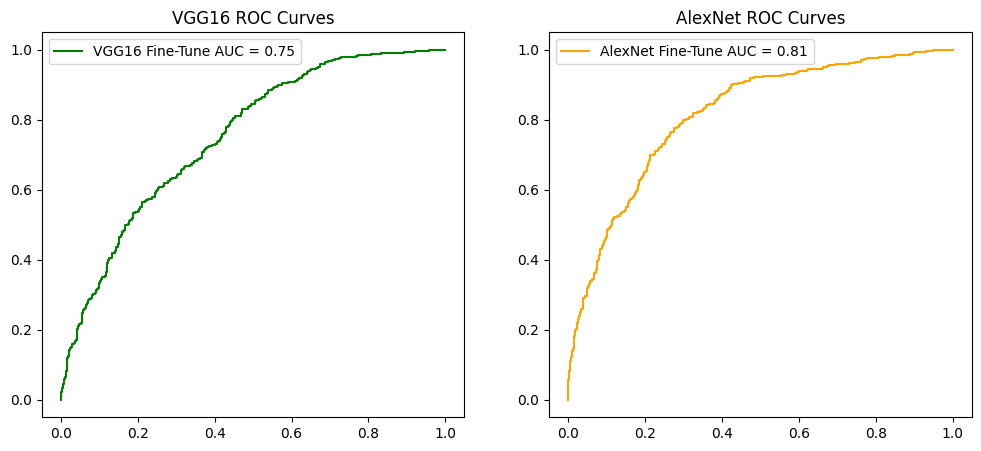

VGG16 Fine-tuned Accuracy: 0.321
AlexNet Fine-tuned Accuracy: 0.249


In [22]:
# Plot ROC curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr_vgg_ft, tpr_vgg_ft, label=f'VGG16 Fine-Tune AUC = {roc_auc_vgg_ft:.2f}', color='green')
plt.title('VGG16 ROC Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fpr_alex_ft, tpr_alex_ft, label=f'AlexNet Fine-Tune AUC = {roc_auc_alex_ft:.2f}', color='orange')
plt.title('AlexNet ROC Curves')
plt.legend()
plt.show()

# Print accuracies
print("VGG16 Fine-tuned Accuracy:", acc_vgg_ft)
print("AlexNet Fine-tuned Accuracy:", acc_alex_ft)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ROC AUC: 0.20934800000000003
Accuracy: 0.5


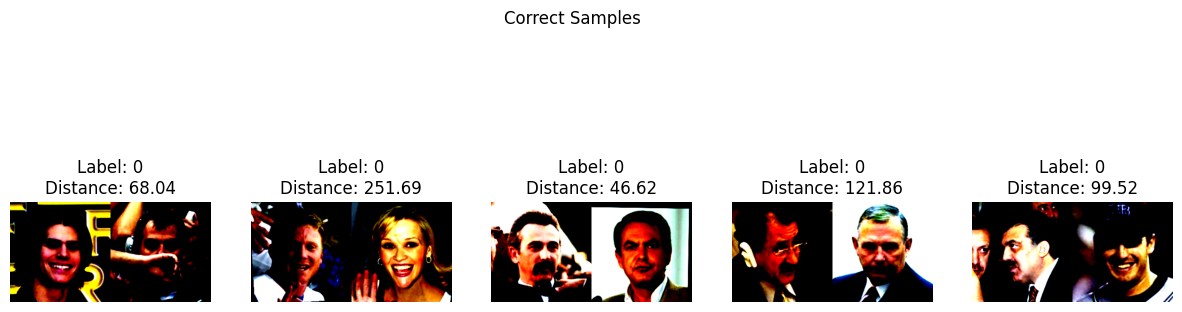

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


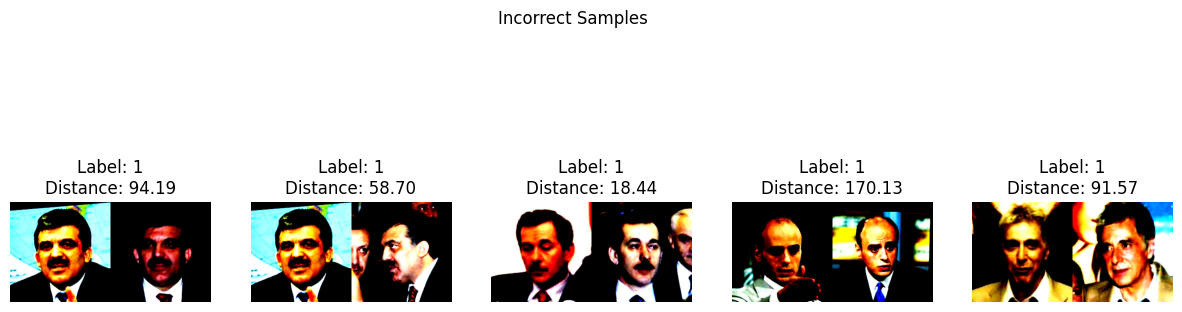

In [16]:
import matplotlib.pyplot as plt

def evaluate_and_visualize(model, test_loader, num_samples=5):
    model.eval()
    embeddings, labels = [], []
    correct_samples = []
    incorrect_samples = []
    
    with torch.no_grad():
        for img0, img1, label in test_loader:
            img0, img1 = img0.to(device), img1.to(device)
            output1, output2 = model(img0, img1)
            dist = torch.norm(output1 - output2, dim=1)
            embeddings.append(dist.cpu().numpy())
            labels.append(label.numpy())

            # Determine if predictions are correct
            predictions = (dist < 1.0).cpu().numpy()  # Assuming 1.0 as a threshold for similarity
            matches = predictions == label.cpu().numpy()

            for i in range(len(matches)):
                if matches[i] and len(correct_samples) < num_samples:
                    correct_samples.append((img0[i].cpu(), img1[i].cpu(), label[i].cpu(), dist[i].cpu()))
                elif not matches[i] and len(incorrect_samples) < num_samples:
                    incorrect_samples.append((img0[i].cpu(), img1[i].cpu(), label[i].cpu(), dist[i].cpu()))

    embeddings = np.concatenate(embeddings)
    labels = np.concatenate(labels)
    fpr, tpr, thresholds = roc_curve(labels, embeddings)
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    accuracy = accuracy_score(labels, embeddings < optimal_threshold)

    return fpr, tpr, roc_auc, accuracy, correct_samples, incorrect_samples

def display_samples(samples, title):
    fig, axes = plt.subplots(1, len(samples), figsize=(15, 5))
    for i, (img0, img1, label, distance) in enumerate(samples):
        ax = axes[i] if len(samples) > 1 else axes
        ax.imshow(torch.cat((img0, img1), dim=2).permute(1, 2, 0).numpy())
        ax.axis('off')
        ax.set_title(f"Label: {label}\nDistance: {distance:.2f}")
    plt.suptitle(title)
    plt.show()

# Example usage after evaluation
fpr, tpr, roc_auc, accuracy, correct_samples, incorrect_samples = evaluate_and_visualize(siamese_alexnet, test_loader)
print("ROC AUC:", roc_auc)
print("Accuracy:", accuracy)

# Display correct and incorrect samples
display_samples(correct_samples, "Correct Samples")
display_samples(incorrect_samples, "Incorrect Samples")
